In [1]:
import cpi 
import yfinance as yf 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from datetime import date
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

plt.style.use('bmh')

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
data = yf.download('GC=F', period='10y', interval='1d', auto_adjust=True)
data = data.resample('M').last().iloc[:-1,:]
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2012-02-29,1789.900024,1790.400024,1669.000000,1709.900024,359
2012-03-31,1660.599976,1670.000000,1659.000000,1669.300049,9825
2012-04-30,1663.000000,1665.699951,1653.000000,1663.400024,36
2012-05-31,1562.699951,1572.599976,1551.800049,1562.599976,5901
2012-06-30,1562.599976,1603.500000,1561.900024,1603.500000,61


In [4]:
def adf_test(x):
    res = adfuller(x, autolag='AIC')
    print('='*40)
    print("***** ADF test *****")
    print("H0: time series is NOT stationary")
    print('-'*40)
    cols = ['Test Statistics', 'p-value', '# of Lags Used', '# of Observations Used']
    for col, val in zip(cols, res[0:4]):
        print(f"{col:25s} {val:.4f}")
    p_val = res[1]
    for k, v in res[4].items():
        alpha = float(k.strip('%'))/100
        name = f"Critical Value ({k})"
        print(f"{name:25s} {v:.4f}", end=' ')
        if p_val < alpha: 
            print("--> Reject H0")
        else:
            print("--> NOT Reject H0")
    print('='*40)
    return res 

In [5]:
def kpss_test(x, h0_type='c'):
    res = kpss(x, regression=h0_type, nlags='auto')
    print('='*40)
    print("***** KPSS test *****")
    print("H0: time series is stationary")
    print('-'*40)
    cols = ['Test Statistics', 'p-value', '# of Lags Used', '# of Observations Used']
    for col, val in zip(cols, res[0:3]):
        print(f"{col:25s} {val:.4f}")
    p_val = res[1]
    for k, v in res[3].items():
        alpha = float(k.strip('%'))/100
        name = f"Critical Value ({k})"
        print(f"{name:25s} {v:.4f}", end=' ')
        if p_val < alpha: 
            print("--> Reject H0")
        else:
            print("--> NOT Reject H0")
    print('='*40)
    return res 

In [6]:
def plot_autocorrelation(x, nlags=40, alpha=0.05):
    fig, ax = plt.subplots(2,1, figsize=(12,8))
    plot_acf(x, lags=nlags, alpha=alpha, ax=ax[0])
    plot_pacf(x, lags=nlags, alpha=alpha, ax=ax[1])
    plt.tight_layout()
    plt.show()

***** ADF test *****
H0: time series is NOT stationary
----------------------------------------
Test Statistics           -1.1697
p-value                   0.6865
# of Lags Used            0.0000
# of Observations Used    119.0000
Critical Value (1%)       -3.4865 --> NOT Reject H0
Critical Value (5%)       -2.8862 --> NOT Reject H0
Critical Value (10%)      -2.5799 --> NOT Reject H0
***** KPSS test *****
H0: time series is stationary
----------------------------------------
Test Statistics           0.6270
p-value                   0.0202
# of Lags Used            6.0000
Critical Value (10%)      0.3470 --> Reject H0
Critical Value (5%)       0.4630 --> Reject H0
Critical Value (2.5%)     0.5740 --> Reject H0
Critical Value (1%)       0.7390 --> NOT Reject H0


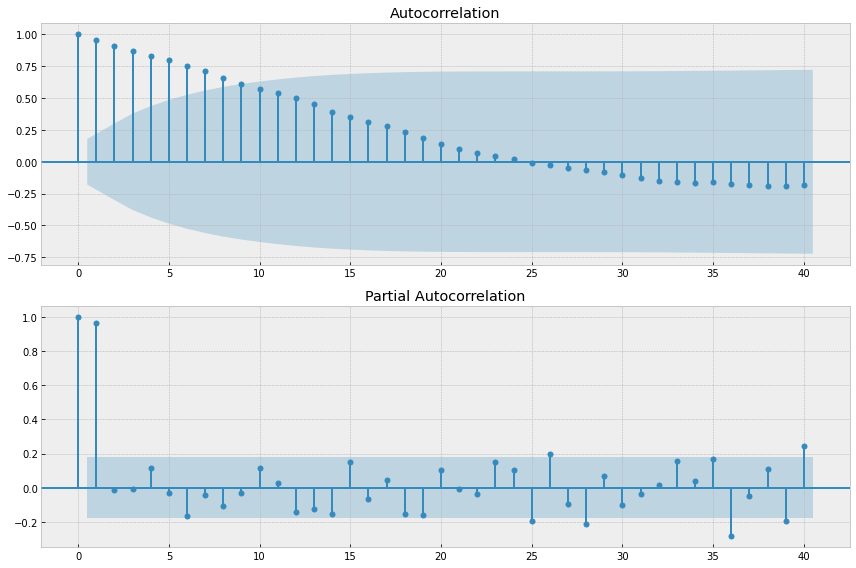

In [7]:
res = adf_test(data.Close)
res = kpss_test(data.Close)
plot_autocorrelation(data.Close)

## Adjusting price to inflation

In [8]:
deflate_date = data.index[-1].to_pydatetime().date()
data['dt_index'] = data.index.map(lambda x: x.to_pydatetime().date())
data['deflated_price'] = data.apply(lambda x: cpi.inflate(x.Close, x.dt_index, to=deflate_date), axis=1)
data.head()

,Open,High,Low,Close,Volume,dt_index,deflated_price
Date,,,,,,,
2012-02-29,1789.900024,1790.400024,1669.000000,1709.900024,359,2012-02-29,2111.607824
2012-03-31,1660.599976,1670.000000,1659.000000,1669.300049,9825,2012-03-31,2045.931724
2012-04-30,1663.000000,1665.699951,1653.000000,1663.400024,36,2012-04-30,2032.560098
2012-05-31,1562.699951,1572.599976,1551.800049,1562.599976,5901,2012-05-31,1911.632652
2012-06-30,1562.599976,1603.500000,1561.900024,1603.500000,61,2012-06-30,1964.549186


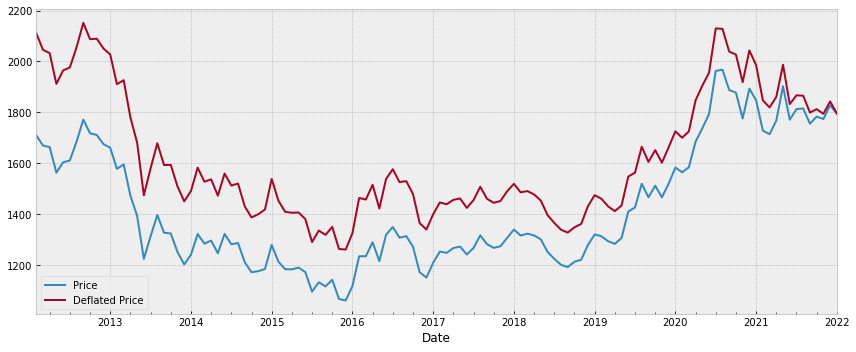

In [9]:
data[['Close', 'deflated_price']].plot(figsize=(12,5))
plt.legend(['Price', 'Deflated Price'])
plt.tight_layout()
plt.show()

***** ADF test *****
H0: time series is NOT stationary
----------------------------------------
Test Statistics           -2.1216
p-value                   0.2359
# of Lags Used            0.0000
# of Observations Used    119.0000
Critical Value (1%)       -3.4865 --> NOT Reject H0
Critical Value (5%)       -2.8862 --> NOT Reject H0
Critical Value (10%)      -2.5799 --> NOT Reject H0
***** KPSS test *****
H0: time series is stationary
----------------------------------------
Test Statistics           0.3758
p-value                   0.0876
# of Lags Used            6.0000
Critical Value (10%)      0.3470 --> Reject H0
Critical Value (5%)       0.4630 --> NOT Reject H0
Critical Value (2.5%)     0.5740 --> NOT Reject H0
Critical Value (1%)       0.7390 --> NOT Reject H0


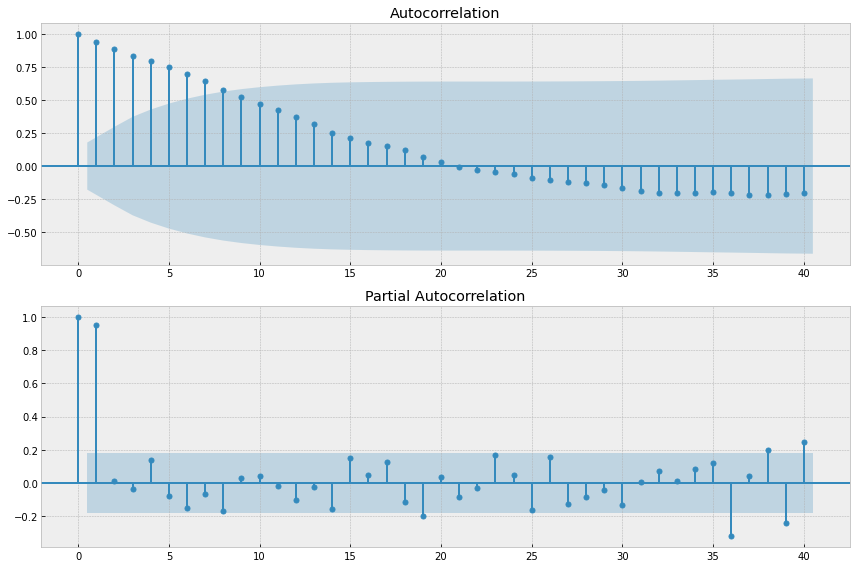

In [10]:
res = adf_test(data.deflated_price)
res = kpss_test(data.deflated_price)
plot_autocorrelation(data.deflated_price)

## Natural logarithm

In [11]:
data['price_log'] = np.log(data.deflated_price)
data['mean_log'] = data.price_log.rolling(12).mean()
data['std_log'] = data.price_log.rolling(12).std()

In [12]:
data .head()

,Open,High,Low,Close,Volume,dt_index,deflated_price,price_log,mean_log,std_log
Date,,,,,,,,,,
2012-02-29,1789.900024,1790.400024,1669.000000,1709.900024,359,2012-02-29,2111.607824,7.655205,NaN,NaN
2012-03-31,1660.599976,1670.000000,1659.000000,1669.300049,9825,2012-03-31,2045.931724,7.623609,NaN,NaN
2012-04-30,1663.000000,1665.699951,1653.000000,1663.400024,36,2012-04-30,2032.560098,7.617051,NaN,NaN
2012-05-31,1562.699951,1572.599976,1551.800049,1562.599976,5901,2012-05-31,1911.632652,7.555713,NaN,NaN
2012-06-30,1562.599976,1603.500000,1561.900024,1603.500000,61,2012-06-30,1964.549186,7.583018,NaN,NaN


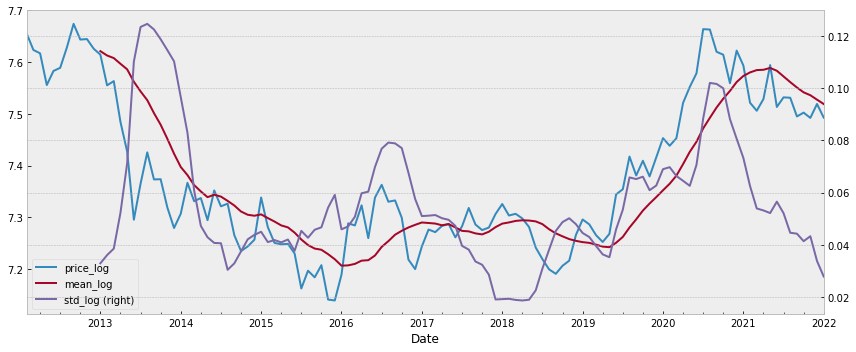

In [13]:
data[['price_log', 'mean_log', 'std_log']].plot(secondary_y='std_log', figsize=(12,5))
plt.tight_layout()
plt.show()

***** ADF test *****
H0: time series is NOT stationary
----------------------------------------
Test Statistics           -2.0473
p-value                   0.2662
# of Lags Used            0.0000
# of Observations Used    119.0000
Critical Value (1%)       -3.4865 --> NOT Reject H0
Critical Value (5%)       -2.8862 --> NOT Reject H0
Critical Value (10%)      -2.5799 --> NOT Reject H0
***** KPSS test *****
H0: time series is stationary
----------------------------------------
Test Statistics           0.3836
p-value                   0.0842
# of Lags Used            6.0000
Critical Value (10%)      0.3470 --> Reject H0
Critical Value (5%)       0.4630 --> NOT Reject H0
Critical Value (2.5%)     0.5740 --> NOT Reject H0
Critical Value (1%)       0.7390 --> NOT Reject H0


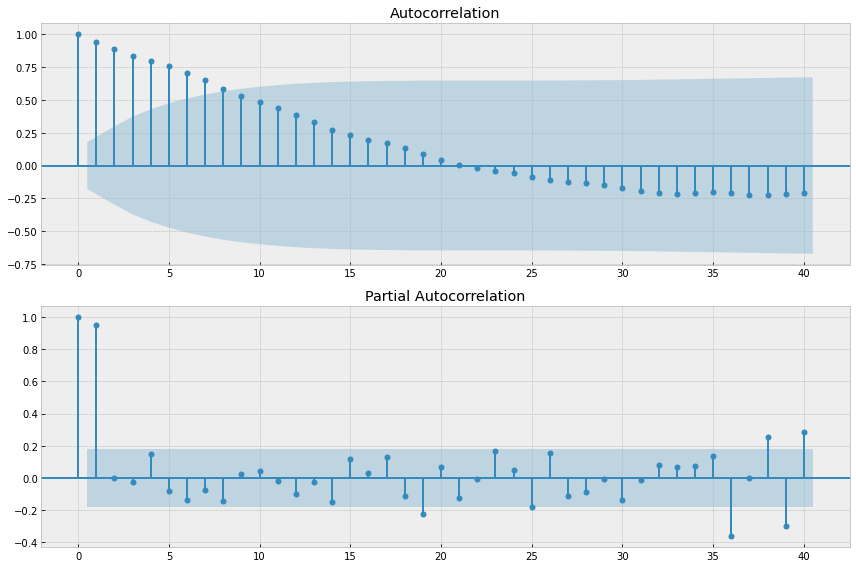

In [14]:
res = adf_test(data.price_log.dropna())
res = kpss_test(data.price_log.dropna())
plot_autocorrelation(data.price_log.dropna())

## Differencing

In [15]:
data['price_log_diff'] = data.price_log.diff(1)
data['mean_log_diff'] = data.price_log_diff.rolling(12).mean()
data['std_log_diff'] = data.price_log_diff.rolling(12).std()
data.head()

,Open,High,Low,Close,Volume,dt_index,deflated_price,price_log,mean_log,std_log,price_log_diff,mean_log_diff,std_log_diff
Date,,,,,,,,,,,,,
2012-02-29,1789.900024,1790.400024,1669.000000,1709.900024,359,2012-02-29,2111.607824,7.655205,NaN,NaN,NaN,NaN,NaN
2012-03-31,1660.599976,1670.000000,1659.000000,1669.300049,9825,2012-03-31,2045.931724,7.623609,NaN,NaN,-0.031596,NaN,NaN
2012-04-30,1663.000000,1665.699951,1653.000000,1663.400024,36,2012-04-30,2032.560098,7.617051,NaN,NaN,-0.006557,NaN,NaN
2012-05-31,1562.699951,1572.599976,1551.800049,1562.599976,5901,2012-05-31,1911.632652,7.555713,NaN,NaN,-0.061338,NaN,NaN
2012-06-30,1562.599976,1603.500000,1561.900024,1603.500000,61,2012-06-30,1964.549186,7.583018,NaN,NaN,0.027305,NaN,NaN


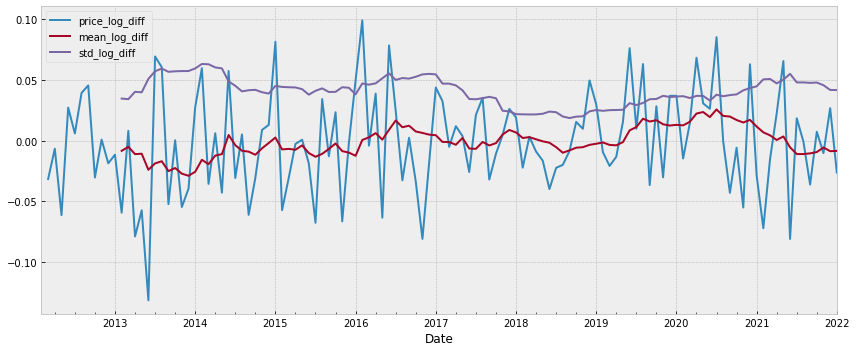

In [16]:
data[['price_log_diff', 'mean_log_diff', 'std_log_diff']].plot(figsize=(12,5))
plt.tight_layout()
plt.show()

***** ADF test *****
H0: time series is NOT stationary
----------------------------------------
Test Statistics           -10.9434
p-value                   0.0000
# of Lags Used            0.0000
# of Observations Used    118.0000
Critical Value (1%)       -3.4870 --> Reject H0
Critical Value (5%)       -2.8864 --> Reject H0
Critical Value (10%)      -2.5800 --> Reject H0
***** KPSS test *****
H0: time series is stationary
----------------------------------------
Test Statistics           0.3055
p-value                   0.1000
# of Lags Used            0.0000
Critical Value (10%)      0.3470 --> NOT Reject H0
Critical Value (5%)       0.4630 --> NOT Reject H0
Critical Value (2.5%)     0.5740 --> NOT Reject H0
Critical Value (1%)       0.7390 --> NOT Reject H0


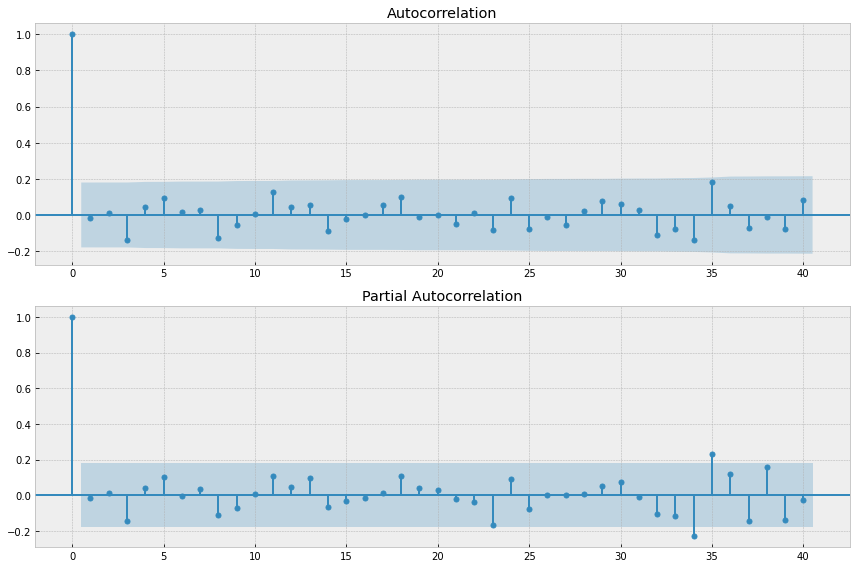

In [17]:
res = adf_test(data.price_log_diff.dropna())
res = kpss_test(data.price_log_diff.dropna())
plot_autocorrelation(data.price_log_diff.dropna())